# **Load data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# for technical indicators
# https://github.com/bukosabino/ta
! pip install ta --quiet

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [4]:
path = '/content/drive/MyDrive/Wisdomise/'

df_raw = pd.read_csv(path + 'df_merged.csv')

# in Github, you can access them from the dataset folder

In [5]:
start_train = '2019'
end_train = '2021-12-01'

start_test = '2022'
end_test = str(df_raw.date.max())

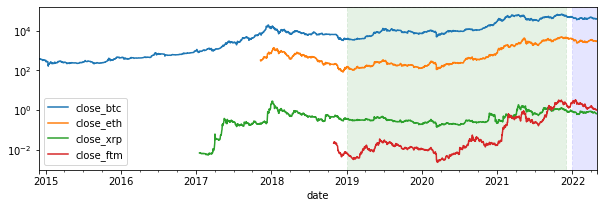

In [6]:
df_raw['date'] = df_raw['date'].apply(pd.Timestamp)

ax = df_raw.plot(x='date', y=['close_btc', 'close_eth', 'close_xrp', 'close_ftm'],
            logy=True, figsize=(10,3))

ax.axvspan(pd.Timestamp(start_train), pd.Timestamp(end_train), color='g', alpha=0.1, ls='dashed')
ax.axvspan(pd.Timestamp(start_test), pd.Timestamp(end_test), color='b', alpha=0.1, ls='dashed')

In [7]:
# cut the dataset to the period where all the coins are available
df_raw = df_raw[df_raw.date > start_train]

assert df_raw.isnull().sum().sum() == 0

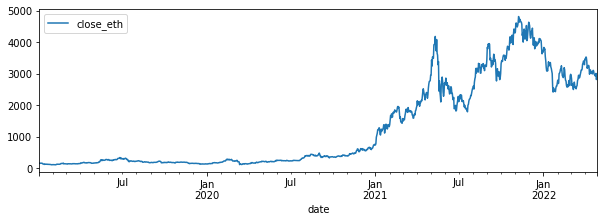

In [8]:
# plot a sample coin
df_raw.plot(x='date', y=['close_eth'], figsize=(10,3))

In [9]:
# desirable columns

assets =  ['btc', 'eth', 'xrp', 'ftm']

close_values = ['close_' + s for s in assets]
low_values = ['low_' + s for s in assets]
high_values = ['high_' + s for s in assets]
volume_values = ['volume_' + s for s in assets]

# **Feature Engineering**

In [10]:
df_with_features = df_raw.copy(deep=True)

**single-asset features**

In [11]:
# functions

from ta.momentum import RSIIndicator
from ta.volume import ChaikinMoneyFlowIndicator

def _calculate_entropy_for_one_vector(x):
    # calculates binned-entropy of a vector
    counts_per_bin, bin_edges = np.histogram(x, bins=3)
    probs = counts_per_bin / x.size
    probs[probs == 0] = 1.0
    return -np.sum(probs * np.log(probs))

def moving_average_ratio(x, short_window, long_window):
    """ ratio of moving-averages for each column
    """
    return x.rolling(short_window).mean() / x.rolling(long_window).mean()

def binned_entropy(x, window):
    return x.rolling(window).apply(lambda x: _calculate_entropy_for_one_vector(x))

def rsi_indicator(x, window):
    return RSIIndicator(x, window=window).rsi()

def cmf_indicator(high_x, low_x, close_x, volume_x, window):
    return ChaikinMoneyFlowIndicator(high_x, low_x, close_x, volume_x, window=window).chaikin_money_flow()


In [12]:
week_to_month_ratio = [x + '_week_to_month_ratio' for x in assets]
three_days_to_week_ratio = [x + '_three_days_to_week_ratio' for x in assets]
binned_entropy_month = [x + '_binned_entropy_month' for x in assets]
two_weeks_rsi = [x + '_two_weeks_rsi' for x in assets]
month_cmf = [x + '_month_cmf' for x in assets]

all_features = [week_to_month_ratio, three_days_to_week_ratio,
                binned_entropy_month, two_weeks_rsi, month_cmf]

for i, x in enumerate(week_to_month_ratio):
    df_with_features[x] = moving_average_ratio(df_raw[close_values[i]], 7, 30)

for i, x in enumerate(three_days_to_week_ratio):
    df_with_features[x] = moving_average_ratio(df_raw[close_values[i]], 3, 7)

for i, x in enumerate(binned_entropy_month):
    df_with_features[x] = binned_entropy(df_raw[close_values[i]], 30)

for i, x in enumerate(two_weeks_rsi):
    df_with_features[x] = rsi_indicator(df_raw[close_values[i]], 14)

for i, x in enumerate(month_cmf):
    df_with_features[x] = cmf_indicator(df_raw[high_values[i]], df_raw[low_values[i]],
                                        df_raw[close_values[i]], df_raw[volume_values[i]], 30)


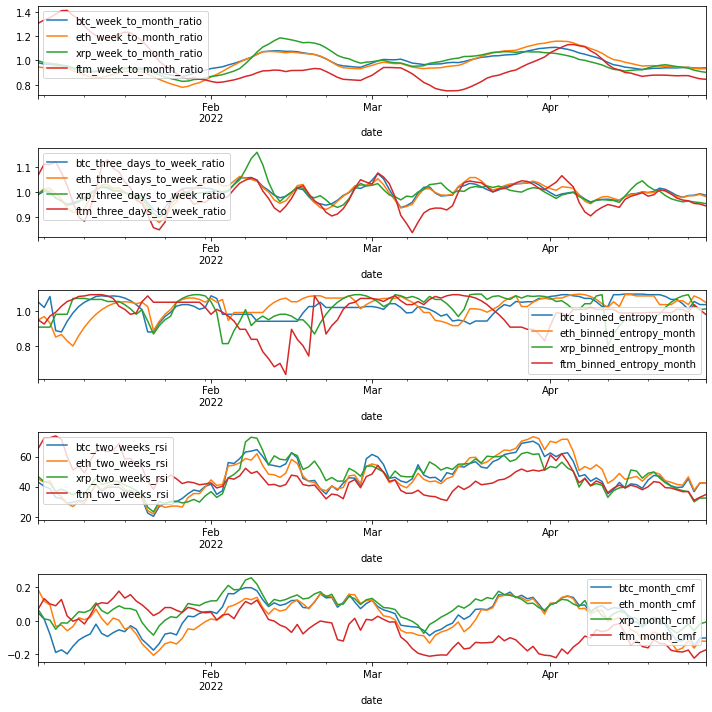

In [13]:
# plot features after 2022 (test phase)
fig, axes = plt.subplots(len(all_features), figsize=(10,10))

for i, x in enumerate(all_features):
    df_with_features[df_with_features.date > start_test].plot(x='date', y=x, ax=axes[i])

fig.tight_layout()

**multi-asset features**

In [14]:
correlation_month = [x + '_corr_with_btc_month' for x in assets[1:]]
correlation_week = [x + '_corr_with_btc_week' for x in assets[1:]]

all_features.append(correlation_month)
all_features.append(correlation_week)

def correlation_two_assets(asset_1, asset_2, window):
    return asset_1.rolling(window).corr(asset_2)

for i, x in enumerate(correlation_month):
    df_with_features[x] = correlation_two_assets(df_raw[close_values[0]], df_raw[close_values[i+1]], 30)

for i, x in enumerate(correlation_week):
    df_with_features[x] = correlation_two_assets(df_raw[close_values[0]], df_raw[close_values[i+1]], 7)

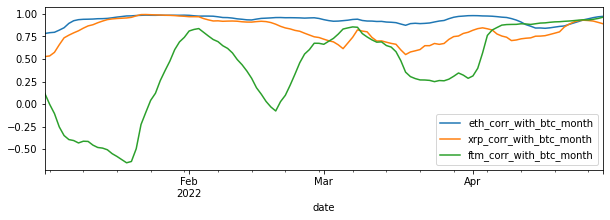

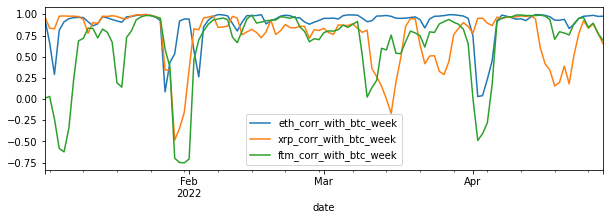

In [15]:
# plot features after 2022 (test phase)
df_with_features[df_with_features.date > start_test].plot(x='date', y=correlation_month, figsize=(10,3))

df_with_features[df_with_features.date > start_test].plot(x='date', y=correlation_week, figsize=(10,3))


# **Check Stationarity**

In [16]:
# replace possible null or inf values with forward or backward values
df_with_features.fillna(method='bfill', inplace=True)
df_with_features.fillna(method='ffill', inplace=True)
assert df_with_features.isnull().sum().sum() == 0

In [17]:
all_features_flat = [item for sublist in all_features for item in sublist]

In [18]:
# check stationarity of features

from statsmodels.tsa.stattools import adfuller

for x in all_features_flat:
    result = adfuller(df_with_features[x])
    if result[1] > 0.05:
        print(f'p-value for {x} is {result[1]}')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Normalization**

In [19]:
df_with_features_train = df_with_features.loc[(start_train <= df_with_features.date) & (df_with_features.date <= end_train)]
df_with_features_test = df_with_features.loc[(start_test <= df_with_features.date) & (df_with_features.date <= end_test)]

df_with_features_train.reset_index(drop=True, inplace=True)
df_with_features_test.reset_index(drop=True, inplace=True)

In [20]:
scaler = preprocessing.StandardScaler().fit(df_with_features_train[all_features_flat])

df_with_features_train[all_features_flat] = scaler.transform(df_with_features_train[all_features_flat])
df_with_features_test[all_features_flat] = scaler.transform(df_with_features_test[all_features_flat])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


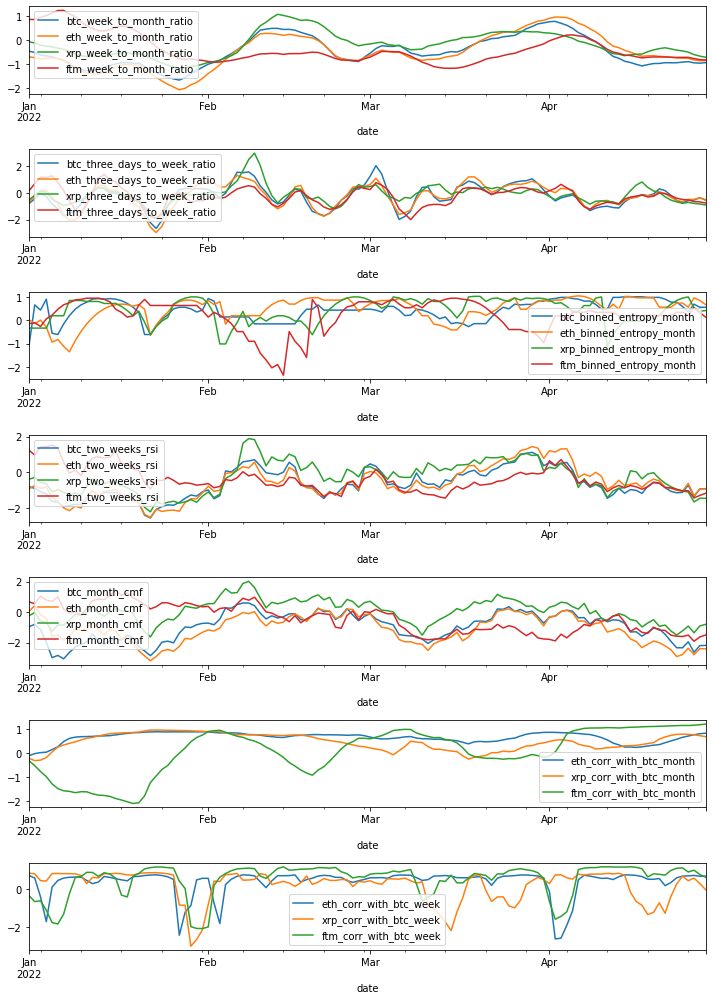

In [21]:
# plot features after 2022 (test phase) after normalization
fig, axes = plt.subplots(len(all_features), figsize=(10,14))

for i, x in enumerate(all_features):
    df_with_features_test.plot(x='date', y=x, ax=axes[i])

fig.tight_layout()

In [22]:
# make sure that the close prices hasn't changed
assert (df_with_features_test[close_values].tail().values == df_raw[close_values].tail().values).all().all()

In [23]:
df_with_features_train.to_csv(path + 'df_with_features_train.csv')
df_with_features_test.to_csv(path + 'df_with_features_test.csv')